In [163]:
from popstar import synthetic, evolution, atmospheres, reddening, ifmr
from popstar.imf import imf, multiplicity
import os, sys, math
from pylab import *
from numpy import *
from gcwork import starset
from gcwork import objects
from gcwork import util
from gcwork import orbits
from astropy.table import Table, Column, MaskedColumn
import matplotlib.pyplot as plt
from astropy.constants import G
from astropy import units as u
from copy import deepcopy

import pdb

In [23]:
# Fetch isochrone
logAge = 6.70 # Age in log(years)
AKs = 1.0 # Ks filter extinction in mags
dist = 4000 # distance in parsecs
metallicity = 0 # metallicity in [M/H]
atm_func = atmospheres.get_merged_atmosphere
evo_merged = evolution.MISTv1()
redlaw = reddening.RedLawCardelli(3.1) # Rv = 3.1
filt_list = ['nirc2,J', 'nirc2,Kp']

iso_dir = 'iso_merged_r1/'

if not os.path.exists(iso_dir):
        os.mkdir(iso_dir)

iso_merged = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=metallicity,
                                 evo_model=evo_merged, atm_func=atm_func,
                                 filters=filt_list, red_law=redlaw,
                                 iso_dir=iso_dir, mass_sampling=3)

In [138]:
# Now we can make the cluster. 
clust_mtot = 10**3.
clust_multiplicity = multiplicity.MultiplicityResolvedDK()

# Multiplicity is defined in the IMF object
clust_imf_Mult = imf.Kroupa_2001(multiplicity=clust_multiplicity)

In [165]:
# Make clusters
clust_Mult = synthetic.ResolvedCluster_ResolvedMult(iso_merged, clust_imf_Mult, clust_mtot)

clust_Mult_ss = clust_Mult.star_systems

In [47]:
def P_to_a(mass, period):
    G_units = G.to("AU3/(M_sun*day2)").value
    a = (period**2*G_units*mass/4/np.pi**2)**(1/3)
    return a

def a_to_P(mass, a):
    G_units = G.to("AU3/(M_sun*day2)").value
    period = (a**3*4*np.pi**2/G_units/mass)**(1/2)
    return period

In [177]:
def add_positions(ss):
    """
    Adds x and y positions randomly in a box of length and width 40000 AU for each system.
    Takes in star system table of cluster object.
    """
    ss_temp = deepcopy(ss)
    
    ss_temp.add_column( Column(np.zeros(len(ss_temp), dtype=float), name='x', description='AU') )
    ss_temp.add_column( Column(np.zeros(len(ss_temp), dtype=float), name='y', description='AU') )
    
    sign_x = np.array([choice([-1,1]) for i in range(len(ss_temp))])
    sign_y = np.array([choice([-1,1]) for i in range(len(ss_temp))])
    ss_temp['x'] = sign_x*20000*np.random.rand(len(ss_temp))
    ss_temp['y'] = sign_y*20000*np.random.rand(len(ss_temp))
    
    return ss_temp

In [178]:
def add_mult_positions(companions, ss_pos):
    """
    Adds x and y positions of multiple companions by transforming keplerian parameters to xyz in arcsec
    using Siyao's code. Then taking those positions in arcsec and going to AU using the distance and adding them
    to the random posiiton of the primary object.
    
    Takes in companion table of the cluster object and the star system table of the cluster object modified by add_positions()
    """
    companions_temp = deepcopy(companions)
    
    companions_temp.add_column( Column(np.zeros(len(companions_temp), dtype=float), name='x', description='AU') )
    companions_temp.add_column( Column(np.zeros(len(companions_temp), dtype=float), name='y', description='AU') )
    
    orb = orbits.Orbit()
    for i in companions_temp:
        orb.w = i['omega'] #degrees
        orb.o = i['Omega'] #degrees
        orb.i = i['i'] #degrees
        orb.e = i['e'] #between 0 and 1
        orb.p = (a_to_P(ss_pos[i['system_idx']]['mass'],10**i['log_a'])*u.day).to("year").value #year
        orb.t0 = (10**logAge)*np.random.rand() #year
        
        (r, v, a) = orb.kep2xyz(np.array([10**logAge]))
        
        #going from arcsecond to AU using small angle approx
        x = (((dist*u.parsec).to("AU")).value)*((r[0][0]*u.arcsec).to("radian").value) #AU
        y = (((dist*u.parsec).to("AU")).value)*((r[0][1]*u.arcsec).to("radian").value) #AU
        
        #putting positions relative to primary object
        i['x'] = ss_pos[i['system_idx']]['x'] + x #AU
        i['y'] = ss_pos[i['system_idx']]['y'] + y #AU
    
    return companions_temp

In [184]:
clust_Mult_ss_pos = add_positions(clust_Mult_ss)
clust_Mult.companions_pos = add_mult_positions(clust_Mult.companions, clust_Mult_ss_pos)

(-30000, 30000)

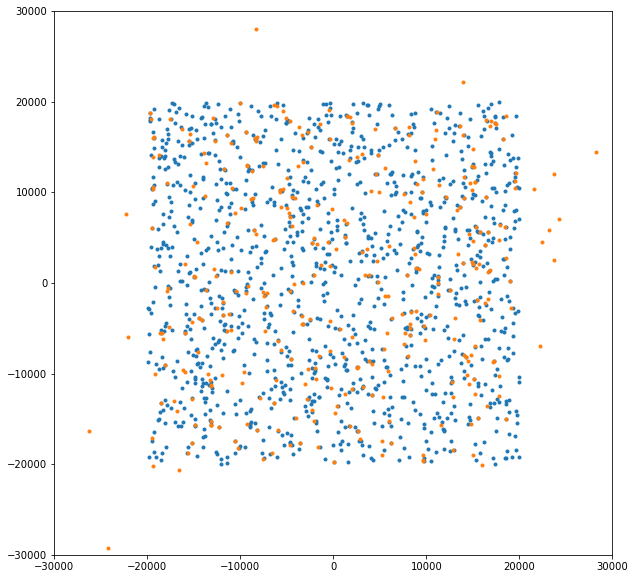

In [183]:
plt.figure(figsize=(10,10))
plt.plot(clust_Mult_ss_pos['x'], clust_Mult_ss_pos['y'],linestyle='none',marker='.' )
plt.plot(clust_Mult.companions_pos['x'], clust_Mult.companions_pos['y'],linestyle='none',marker='.' )
plt.xlim(-30000, 30000)
plt.ylim(-30000, 30000)

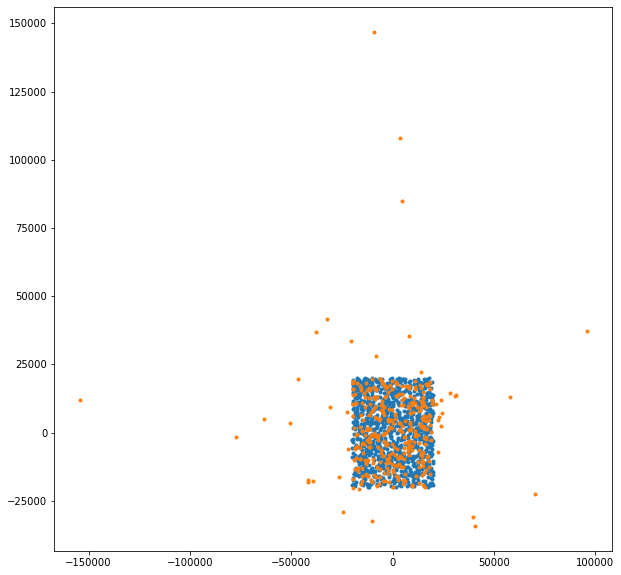

In [182]:
plt.figure(figsize=(10,10))
plt.plot(clust_Mult_ss_pos['x'], clust_Mult_ss_pos['y'],linestyle='none',marker='.' )
plt.plot(clust_Mult.companions_pos['x'], clust_Mult.companions_pos['y'],linestyle='none',marker='.' )
#plt.xlim(-30000, 30000)
#plt.ylim(-30000, 30000)